Comparing 2 model sets: based on posts texts cleaned up from html tags, linnks, emojis, etc and original downloaded text.
Looks like, a model based on original, not altered text is significantly better.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#data and experiment log in Excel file 
import pandas as pd
import numpy as np

In [3]:
#for analyzing results: charts and t-test
import scipy.stats as stats
from matplotlib import pyplot as plt

In [4]:
#Saving into log (Excel file)
import openpyxl 
def SaveToExperimentLog(Experiments_file, LogEntry, data):
    book = openpyxl.load_workbook(Experiments_file)
    writer = pd.ExcelWriter(Experiments_file, engine='openpyxl') 
    writer.book = book

    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

    data.to_excel(writer, LogEntry[0:29],index=False)

    writer.save()
    writer.close()

In [5]:
#Experiment
#Experiments log file 
Experiments_file='/content/drive/MyDrive/Colab Notebooks/Projects/eva/ExperimentLogs/fedulya.xlsx'
Experiment_name='Comparing'

#Significance level
alpha=0.05
confidence = 1 - alpha

In [6]:
Experiment = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_name)
Experiment.tail()

,Model,Score,0,1,2,3,4,5,6,7,8,9,mean,sem,std,median,Shapiro test,Confidence Interval (+/-)
0,target is original_message,test_fedulya-f1-score,0.859668,0.863936,0.870817,0.864304,0.864081,0.864413,0.871423,0.865315,0.868687,0.862759,0.865540,0.001165,0.003684,0.864358,The score is normally distributed with alpha=0.05,0.002635
1,target is message,test_fedulya-f1-score,0.838986,0.840653,0.840643,0.842144,0.843365,0.842684,0.832733,0.840661,0.839795,0.835556,0.839722,0.001040,0.003287,0.840648,The score is normally distributed with alpha=0.05,0.002352


## t-test

In [7]:
#set a specific BaseModel name or just select with min or max mean score
#The rest of the models will be compared to BaseModel
BaseModel=Experiment[Experiment['mean']==Experiment['mean'].max()]['Model'].values[0]
#BaseModel='Model2'

folds_columns=['0','1','2','3','4','5','6','7','8','9']

BaseModelResults=Experiment[Experiment['Model']==BaseModel][folds_columns].values[0].tolist()
shapiro_test = stats.shapiro(BaseModelResults)
shapiro_test_pvalue = shapiro_test[1]
if shapiro_test_pvalue < alpha:
  Experiment['t-test Comment'] = 'The null hypothesis that the score are normally distributed is rejected with alpha=%s'%alpha
else:
  Experiment['t-test Comment'] = 'This is BaseModel in the comparizon.'

In [8]:
#t-test for each record in Experiment

for index, model in Experiment.iterrows():
  if model['Model']!=BaseModel:
    AnalyzedModelResults=model[folds_columns].values.tolist()
    shapiro_test = stats.shapiro(AnalyzedModelResults)
    shapiro_test_pvalue = shapiro_test[1]
    if shapiro_test_pvalue < alpha:
      models_params.at[index,'Shapiro test'] = 'The null hypothesis that the score are normally distributed is rejected with alpha=%s'%alpha
    else:
      t=stats.ttest_rel(BaseModelResults,AnalyzedModelResults)
      Experiment.at[index,'t-statistic']= t.statistic
      Experiment.at[index,'t-test pvalue'] = t.pvalue 
      if t.pvalue>=alpha:
        Experiment.at[index,'t-test Comment'] = 'No difference with %s with %s significance level'%(BaseModel,alpha)
      else:
        Experiment.at[index,'t-test Comment'] = 'There is a difference with %s with %s significance level'%(BaseModel,alpha)
  else:
    Experiment.at[index,'t-statistic']= np.nan
    Experiment.at[index,'t-test pvalue'] = np.nan
Experiment

,Model,Score,0,1,2,3,4,5,6,7,8,9,mean,sem,std,median,Shapiro test,Confidence Interval (+/-),t-test Comment,t-statistic,t-test pvalue
0,target is original_message,test_fedulya-f1-score,0.859668,0.863936,0.870817,0.864304,0.864081,0.864413,0.871423,0.865315,0.868687,0.862759,0.865540,0.001165,0.003684,0.864358,The score is normally distributed with alpha=0.05,0.002635,This is BaseModel in the comparizon.,NaN,NaN
1,target is message,test_fedulya-f1-score,0.838986,0.840653,0.840643,0.842144,0.843365,0.842684,0.832733,0.840661,0.839795,0.835556,0.839722,0.001040,0.003287,0.840648,The score is normally distributed with alpha=0.05,0.002352,There is a difference with target is original_...,14.474381,1.537167e-07


## Confidence interval of the difference between models scores

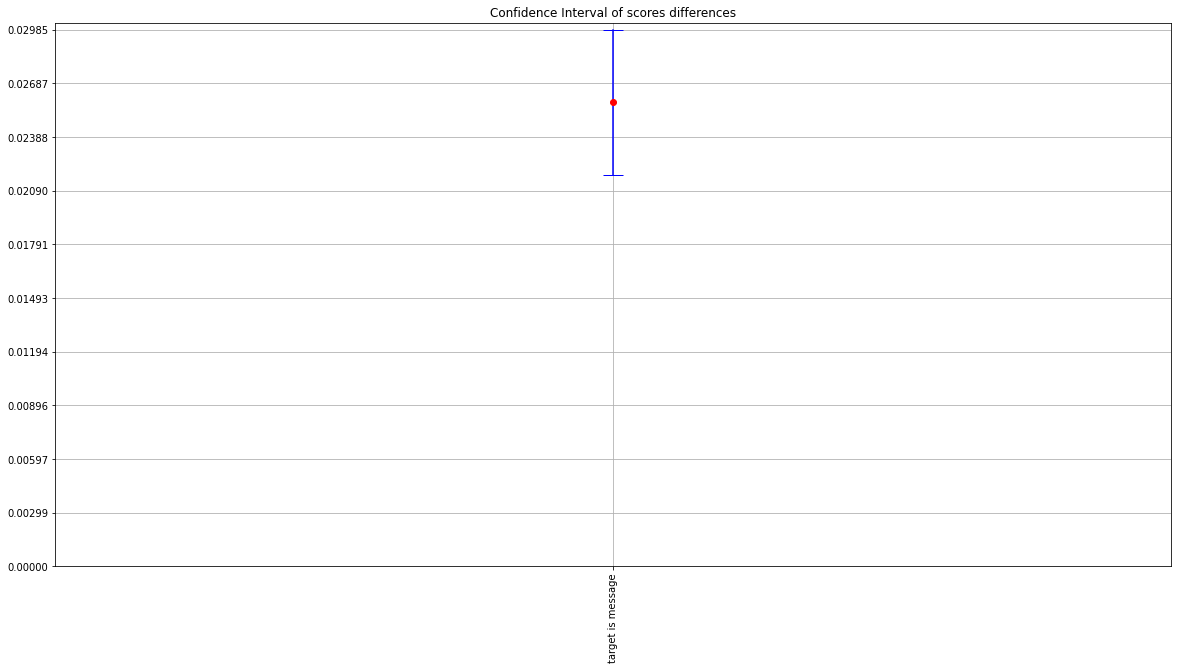

In [9]:
CI_name = list()
CI_mean = list()
CI_lower = list()
CI_upper = list()
for index, model in Experiment.iterrows():
  if model['Model']!=BaseModel:
    AnalyzedModelResults=model[folds_columns].values.tolist()
    diff=[np.abs(y - x) for y, x in zip(BaseModelResults,AnalyzedModelResults)]
    CI=stats.t.interval(1-alpha, len(diff)-1, loc=np.mean(diff), scale=stats.sem(diff))
    CI_name.append(model['Model'])
    CI_mean.append(np.mean(diff))
    CI_lower.append(CI[0])
    CI_upper.append(CI[1])  
    #models_params.at[index,'BaseModel Diff mean'] = np.mean(diff)
    #models_params.at[index,'BaseModel CI lower'] = CI[0]
    #models_params.at[index,'BaseModel CI upper'] = CI[1]                       
CI_df = pd.DataFrame(list(zip(CI_name, CI_mean, CI_lower, CI_upper)), columns=['Model','mean','lower','upper'])
plt.figure(figsize=(20,10))
dim=np.arange(0,CI_df['upper'].max() + CI_df['upper'].max()/10,CI_df['upper'].max()/10)
for lower,mean,upper,x in zip(CI_df['lower'],CI_df['mean'],CI_df['upper'],range(len(CI_df))):
  plt.plot((x,x),(lower,upper),'r_-',markersize=20,color='blue')
  plt.plot(x,mean,'ro',color='red')
plt.xticks(range(len(CI_df)),list(CI_df['Model']),rotation=90)
plt.yticks(dim)
plt.grid(axis='both')
#plt.margins(x=2)
_=plt.title('Confidence Interval of scores differences')
lst_chart_filenames=list()
#chart_filename=temp_folder+'Confidence Interval of Kappa test scores differences.png'
#lst_chart_filenames.append(chart_filename)
#plt.savefig(chart_filename,format='png')

In [10]:
SaveToExperimentLog(Experiments_file, Experiment_name, Experiment)